# Heterogeneity study

We study the results from notebook 2, and will try to emphasize heterogeities in the result. We will also conduct some tests to test the strength of our results. 

In [101]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from os import path

In [102]:
# Data folders
data_folder = "data/" 
result_folder = "results/"

In [103]:
df = pd.read_csv( path.join( result_folder, 'AR.csv'))
df = df.drop_duplicates(subset = ['ISIN'])

# We only keep the anormal returns, not the errors
def is_float(str):
    try :
        float(str)
        return True
    except :
        return False

filter = np.all([[is_float(df[f'AR_{2*j}'].iloc[i]) for i in range(len(df))] for j in range(5,16)], axis = 0)
df = df[filter]
df[ df.columns[1:] ] = df[ df.columns[1:] ].apply(pd.to_numeric)


### Strength test

The main source of error with the market model is that the anormal return may vary with the time window used for the linear regression. We have : $AR = AR(i,t)$ where i is the event and t is the time window used for the linear regression. Here we want to see if we can define an anormal return so that $AR = AR(i)$. Morerover, we want see if 
$AR(i) = \mathbb{E} (AR(i,t))$ could be relevant.

We will study the disparities in our results to see if they depend or not of the time period used for the linear regression. We want to see if the fifferent anormal return are close or not of the average anormal return for one firm. We also want to see the standard deviation of our results. The goal is to see if it can be releavant to keep the average anormal return for each firm for further studies.

In [104]:
#Standard deviation
Sigma = np.array([np.std(df.iloc[i][1:]) for i in range(len(df))])
print(f'Average standart deviation : {np.mean(Sigma)}')


Average standart deviation : 1.0752814499415833


We will represent the repartition of standard deviation, to see how many results present an important standard deviation

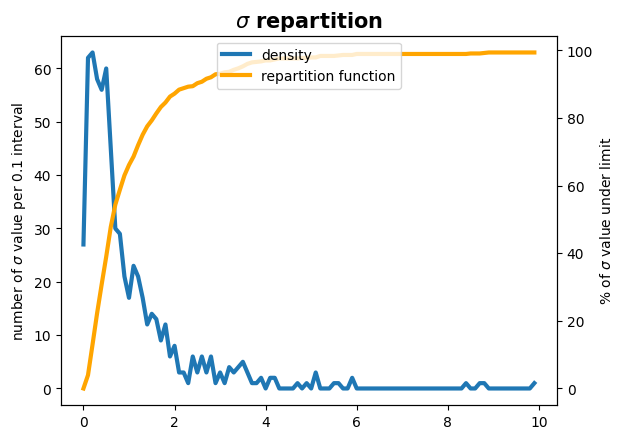

In [105]:
Sigma_density = np.array([np.sum(np.logical_and(Sigma < 0.1*(i+1) , Sigma >=  0.1*i)) for i in range(100)])
Sigma_inf_percentage = np.array([ np.sum( Sigma< 0.1*i)*100/len(Sigma) for i in range(100)])
x = np.array([ 0.1 * i  for i in range(100)])

fig, ax = plt.subplots()
ax.plot(x, Sigma_density, linewidth = 3)
ax.set_ylabel('number of $\sigma$ value per 0.1 interval')


ax2 = ax.twinx()
ax2.plot(x, Sigma_inf_percentage,  color = 'orange', linewidth = 3)
ax2.set_ylabel('$\%$ of $\sigma$ value under limit')

lines = [ax.get_lines()[0], ax2.get_lines()[0]]
plt.legend(lines, ['density', 'repartition function'], loc="upper center")
plt.title('$\sigma$ repartition', fontsize = 15 , fontweight = 'semibold')
plt.show();

If we only keep the results where $\sigma < 5$, we will still have more than 95% of the data, while eliminating anormal values. 

In [106]:
filter = Sigma < 5
df_filtered = df[filter]
frac = np.round( (len(df_filtered)/ len(df))*100, 2)
print(f'Percentage of data kept : {frac} %')

Percentage of data kept : 97.95 %


C:\Users\alexa\AppData\Local\Temp\ipykernel_12276\3644897373.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  average = df_filtered.mean()


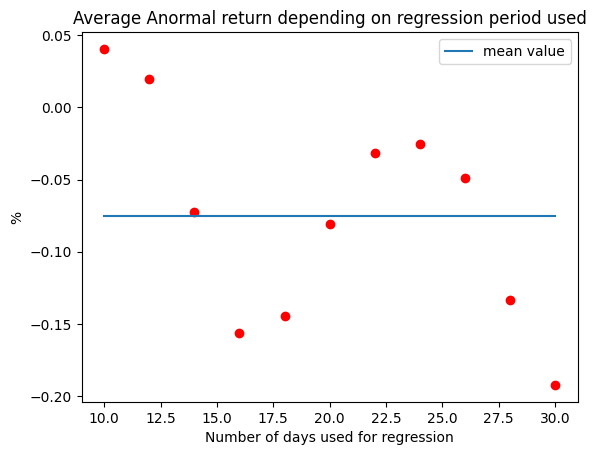

In [107]:
average = df_filtered.mean()
Average = average.mean()*np.ones(11)

x = range(10, 31, 2)
plt.scatter(x, average, color = 'red')
plt.xlabel('Number of days used for regression')
plt.plot(x, Average, label='mean value' )
plt.legend()
plt.ylabel('%')
plt.title('Average Anormal return depending on regression period used')
plt.show();

The average value of anormal returns depends of the number of days used for regression, but remain close to the mean one

In [113]:
# New average and min/max values
AR_mean = np.array([ np.mean(df_filtered.iloc[i][1:]) for i in range(len(df_filtered))])
AR_max = np.array([ np.max(df_filtered.iloc[i][1:]) for i in range(len(df_filtered))])
AR_min = np.array([ np.min(df_filtered.iloc[i][1:]) for i in range(len(df_filtered))])

We will compare the average anormal return with the min and max values

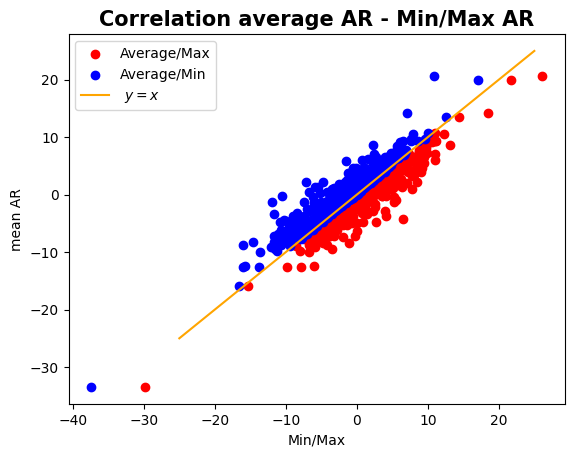

In [114]:
plt.figure()
plt.scatter(AR_max,  AR_mean, color = 'red' , label = 'Average/Max')
plt.scatter(AR_min,  AR_mean, color = 'blue' , label = 'Average/Min')
plt.plot([-25, 25] , [-25, 25] , color ='orange', label = ' $y = x$')
plt.xlabel('Min/Max')
plt.ylabel('mean AR')
plt.title('Correlation average AR - Min/Max AR', fontweight = 'semibold' , fontsize = 15)
plt.legend()
#plt.savefig(path.join(result_folder, 'correlation.png'))
plt.show();


The results depends on the time period used for regression, but are all close to the average value. 

 ### For the rest of the noteboook, we will focus on $AR(i) = \mathbb{E}(AR(i,t))$


### Result study

In [110]:
print(f'average anormal return : {np.mean(AR_moyen)} %')

average anormal return : -0.07505212225244337 %


The first we notice is that the global effect is **positive**, but **close to 0** $( \approx  0.07 \%)$
Moreover, given the fact that this value might be influenced by the choice of data period used for the market model, we can only conclude that on our set of companies, the emission mitigation target release have no significant global impact. 

We will now try to reveal heterogenities

In [111]:
# We will need more informations about the companies
info = pd.read_csv(path.join(data_folder, 'info.csv') , sep =';', encoding= 'latin_1',
                   names = ['name' , 'ISIN' , 'Lei' , 'Country' , 'Continent',
                            'sector' , 'type']) 


info = info.drop_duplicates(subset = ['ISIN'])
info = info[info['ISIN'].notna()].set_index('ISIN')


In [117]:
# Sectors and types
isin = np.array(df_filtered['ISIN'])
sector = np.array([info.loc[i]['sector'] for i in isin])
company_type = np.array([info.loc[i]['type'] for i in isin])
# Average
AR_mean = np.array([ np.mean(df_filtered.iloc[i][1:]) for i in range(len(df_filtered))])


In [118]:
new_df = pd.DataFrame({'type' : company_type, 'AR' : AR_mean })
g =(new_df.groupby( 'type')).mean()
print(g)

new_df = pd.DataFrame({'sector' : sector, 'AR' : AR_mean })
g =(new_df.groupby( 'sector')).mean()
print(g)


                                  AR
type                                
Company                    -0.099412
Financial Institution      -1.127961
Small or Medium Enterprise  0.445048
                                                          AR
sector                                                      
Aerospace and Defense                              -1.700183
Air Freight Transportation and Logistics            0.620291
Air Transportation - Airlines                       1.949685
Automobiles and Components                         -0.546518
Banks, Diverse Financials, Insurance               -1.127961
Building Products                                  -0.513451
Chemicals                                           1.404229
Construction Materials                              0.684830
Construction and Engineering                        1.060111
Consumer Durables, Household and Personal Products  0.276738
Containers and Packaging                            0.103281
Education Services    